In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt

pypfopt.__version__

'1.5.4'

In [20]:
%load_ext autoreload
%autoreload 2


In [23]:
from portfolio_analysis.data import historical_prices, historical_daily_price
from portfolio_analysis.api import apikey

In [ ]:
from pandas_datareader import data as pdr

In [157]:
tickers = ["AAPL",
"GD",
"IAU",
"MSFT",
"NVO",
"PINC",
"TD.TO",
"U.UN.TO",
"VEQT.TO",
"VOO",
"XEG.TO"]

In [82]:
def fmp_download(tickers, apikey, prices_df=pd.DataFrame()):
    prices_df = prices_df.reset_index()
    prices_df = prices_df.rename(columns={"DATE":"date"})
    for ticker in tickers:
        if ticker in prices_df.columns:
            continue
        try:
            prices = historical_daily_price(ticker, apikey=apikey)
        except:
            print(f"Failed for symbol: {ticker}")
            continue
        df = prices[["date","close"]]
        df.columns = ['date', ticker]
        if len(prices_df) == 0:
            prices_df = df
        else:
            prices_df = prices_df.merge(df, on='date',how='outer')
    prices_df = prices_df.rename(columns={"date":"DATE"})
    prices_df = prices_df.set_index('DATE')
    return prices_df

In [158]:
prices = fmp_download(tickers, apikey, prices_df= prices)

Failed for symbol: U.UN.TO


In [ ]:
# Follow these cookbooks - https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook

In [58]:
#https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
from pypfopt import risk_models, expected_returns
from pypfopt import plotting
from pypfopt import EfficientFrontier, objective_functions


In [176]:
prices_df = prices.iloc[0:100,:].sort_values('DATE')

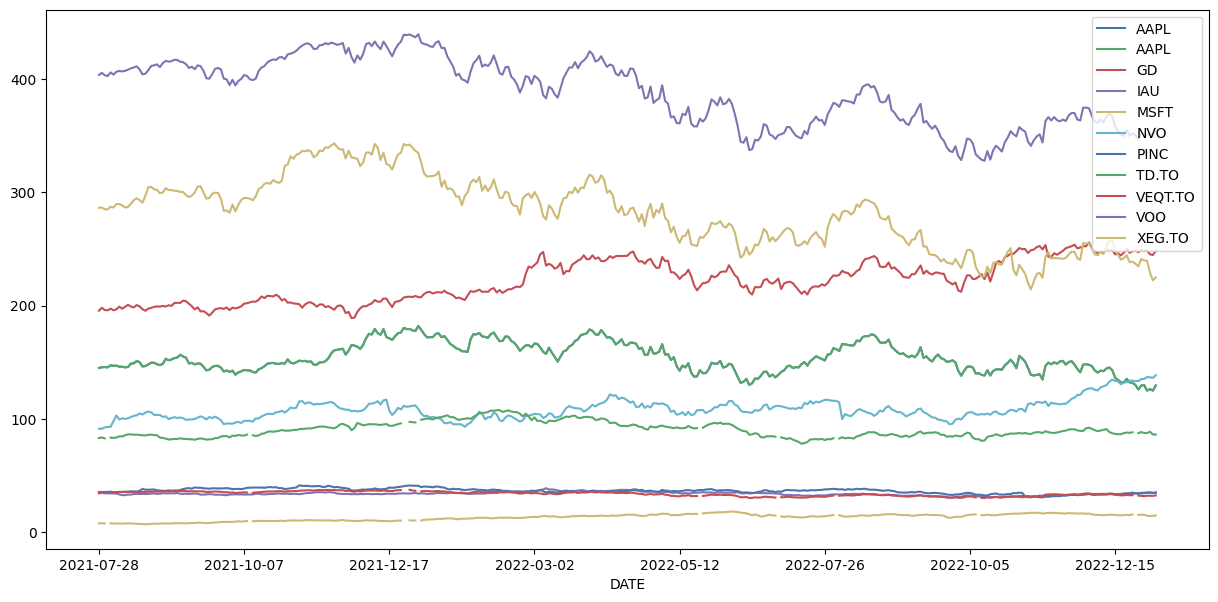

In [160]:
# prices_100
for index, ticker in enumerate(tickers):
    if ticker not in prices_df.columns:
        continue
    if index == 0:
        prices_df[f'{ticker}'].plot(figsize = (15,7))
    prices_df[f'{ticker}'].plot()
plt.legend()
# tcs['MA200'].plot()

In [161]:
prices_df

,AAPL,GD,IAU,MSFT,NVO,PINC,TD.TO,VEQT.TO,VOO,XEG.TO
DATE,,,,,,,,,,
2021-07-28,144.979996,195.509995,34.44,286.220001,91.489998,35.650002,83.250000,35.369999,403.390015,8.060000
2021-07-29,145.639999,198.139999,34.83,286.500000,91.370003,35.740002,83.699997,35.360001,405.130005,8.100000
2021-07-30,145.860001,196.029999,34.56,284.910004,92.599998,35.639999,82.949997,35.240002,403.149994,8.020001
2021-08-02,145.520004,195.830002,34.53,284.820007,93.000000,35.680000,NaN,NaN,402.329987,NaN
2021-08-03,147.360001,197.320007,34.49,287.119995,93.120003,35.990002,83.620003,35.610001,405.579987,8.090000
...,...,...,...,...,...,...,...,...,...,...
2022-12-30,129.930000,248.110000,34.59,239.820000,135.340000,34.980000,87.669998,32.100000,351.340000,15.650000
2023-01-03,125.070000,248.600000,34.88,239.580000,136.960000,35.270000,87.669998,32.340000,349.990000,14.730000
2023-01-04,126.360000,245.220000,35.21,229.100000,136.770000,35.260000,88.809998,32.370000,352.510000,14.500000


Min volatility with a transaction cost objective
Let's say that you already have a portfolio, and want to now optimize it. It could be quite expensive to completely reallocate, so you may want to take into account transaction costs. PyPortfolioOpt provides a simple objective to account for this.

Note: this objective will not play nicely with max_sharpe

In [126]:
# Pretend that you started with a default-weight allocation
# initial_weights = np.array([1/len(tickers)] * len(tickers))
initial_weights = np.array([0.151127757,
0.032855962,
0.070091914,
0.101521996,
0.054900967,
0.023437844,
0.057990196,
0.31158767,
0.159222073,
0])

In [131]:
prices.head()

,AAPL,GD,IAU,MSFT,NVO,PINC,TD.TO,VEQT.TO,VOO,XLE
DATE,,,,,,,,,,
2023-01-06,129.62,248.25,35.43,224.93,138.64,35.01,86.370000,32.69,356.59,87.56
2023-01-05,125.02,244.62,34.79,222.31,136.25,34.90,86.410004,32.25,348.66,85.93
2023-01-04,126.36,245.22,35.21,229.10,136.77,35.26,88.809998,32.37,352.51,84.39
2023-01-03,125.07,248.60,34.88,239.58,136.96,35.27,87.669998,32.34,349.99,84.40
2022-12-30,129.93,248.11,34.59,239.82,135.34,34.98,87.669998,32.10,351.34,87.47


In [162]:
past_df = prices.iloc[100:,:]
future_df = prices.iloc[0:100,:]

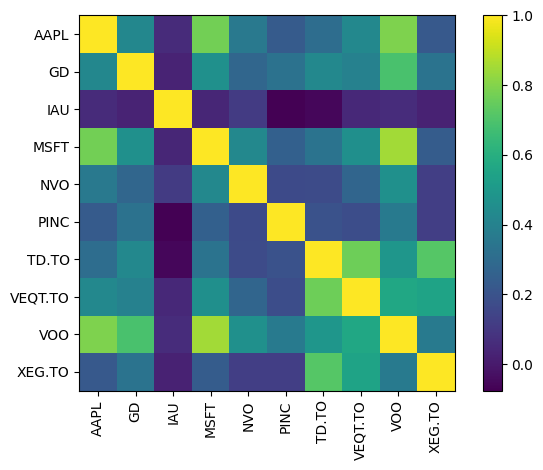

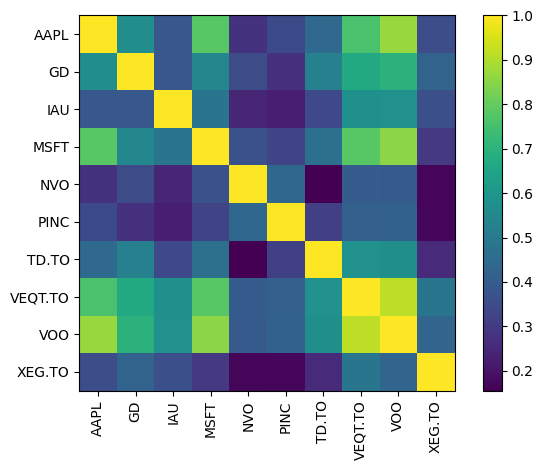

In [163]:
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

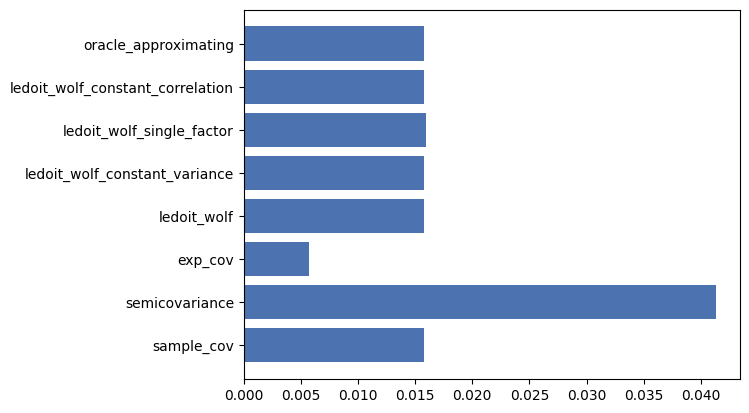

In [164]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(prices_df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

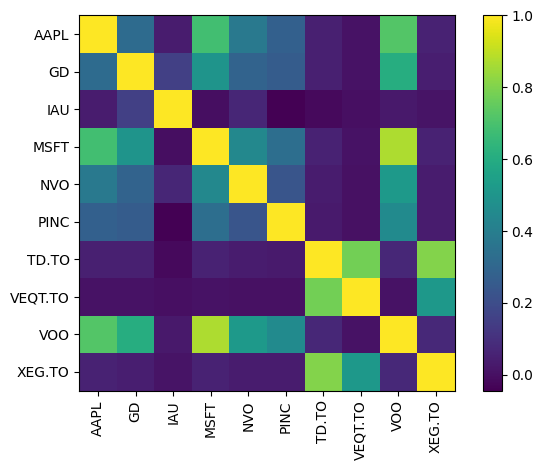

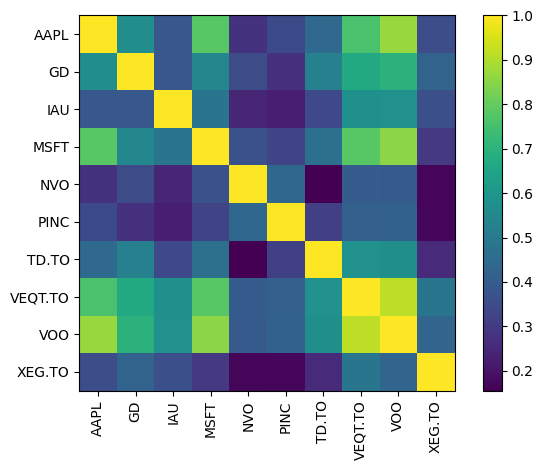

In [165]:
exp_cov = risk_models.exp_cov(past_df)
plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

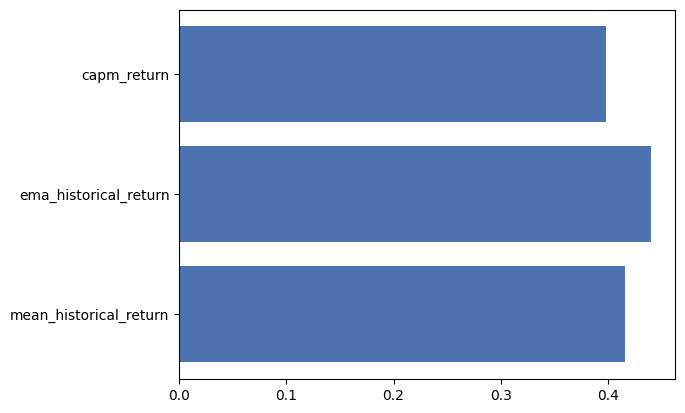

In [133]:

future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

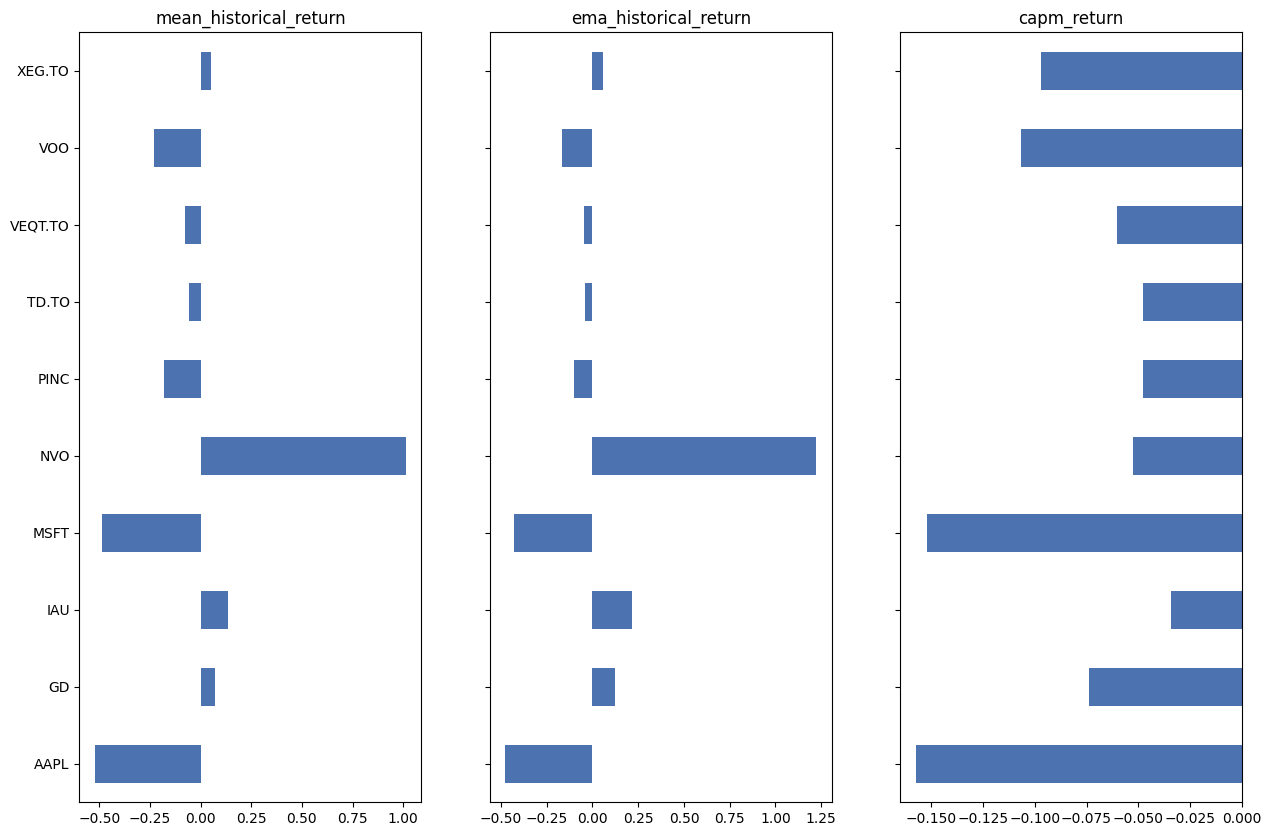

In [180]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(prices_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

<AxesSubplot: >

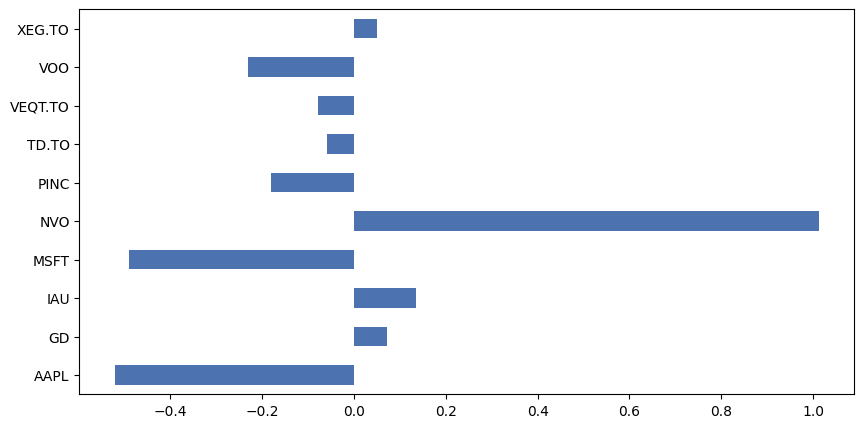

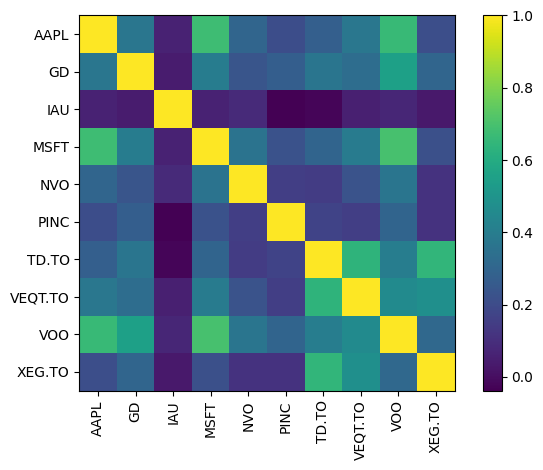

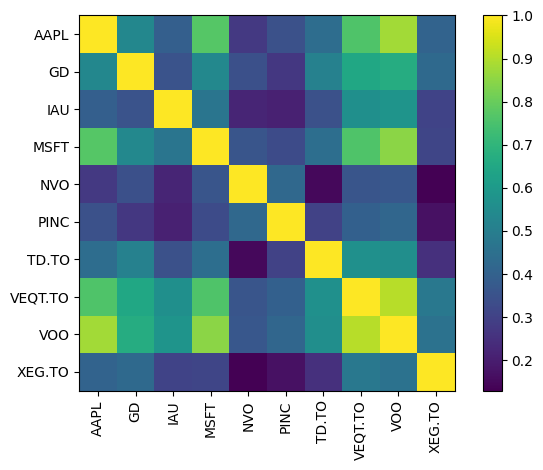

In [181]:
# mu = expected_returns.capm_return(prices_df)
mu = expected_returns.return_model(prices_df, method='mean_historical_return')
exp_cov
# S = risk_models.semicovariance(prices_df)
S_1 = risk_models.exp_cov(prices_df)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
mu
mu.plot.barh(figsize=(10,5))
plotting.plot_covariance(S, plot_correlation=True)
plotting.plot_covariance(S_1, plot_correlation=True)

In [189]:
mu

AAPL      -0.520626
GD         0.072917
IAU        0.135046
MSFT      -0.488524
NVO        1.013124
PINC      -0.179520
TD.TO     -0.059318
VEQT.TO   -0.078712
VOO       -0.229454
XEG.TO     0.050985
dtype: float64

In [194]:
ef = EfficientFrontier(mu, S_1, weight_bounds=(0, 1)) #When bounds are None, None then it will find short positions

# 1% broker commission
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
# ef.min_volatility()
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0),
             ('GD', 0.01066),
             ('IAU', 0.34181),
             ('MSFT', 0.0),
             ('NVO', 0.18911),
             ('PINC', 0.05632),
             ('TD.TO', 0.1669),
             ('VEQT.TO', 0.23521),
             ('VOO', 0.0),
             ('XEG.TO', 0.0)])

In [195]:
ef.portfolio_performance(verbose=True)

Expected annual return: 20.0%
Annual volatility: 13.1%
Sharpe Ratio: 1.37


(0.19999999999999996, 0.13124842220296132, 1.3714450579958186)

In [66]:
ef.portfolio_performance(verbose=True);


Expected annual return: -4.8%
Annual volatility: 10.2%
Sharpe Ratio: -0.67
